In [41]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import numpy as np
%matplotlib inline

In [42]:
def plot_model_line(x, y, x_in, y_out, title="", xlabel="", ylabel="", length=7, height=5):
    fig, ax = plt.subplots(figsize=(length,height))
    if (title != ""):
        ax.set_title(title)
    if (xlabel != ""):
        ax.set_xlabel(xlabel)
    if (ylabel != ""):
        ax.set_ylabel(ylabel)
    ax.plot(x, y, c='r', marker="s", label='Input')
    #ax.bar(x, y, label='Input')
    ax.plot(x_in, y_out, label='Predicted')
    plt.legend(loc='upper left');
    plt.show()
    
def get_month_to_month_ridership_trends(station_data, months, station):
    month_key='Month'
    x_label ="index"
    y_label="Avg_Weekday"
    formula = "Avg_Weekday~index"
    coefs = []
    for month in months: 
        sample = station_data[station_data[month_key] == month]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()
        coefs.append(lm.params[x_label])
    
    return coefs
    
def interyear_ridership_trends(ridership_data, years, station):    
    year_key = "Year"
    formula = "Avg_Weekday~index"
    x_label ="index"
    y_label="Avg_Weekday"
    plt.figure(figsize=(20,5))
    height = 5
    length = 10
    for year in years:
        sample = ridership_data[ridership_data[year_key] == year]
        lm = smf.ols(formula = formula, data = sample).fit()
        predicted_ys = lm.predict()

        fig, ax = plt.subplots(figsize=(length,height))  
        ax.set_title("{}: Yearly Trends in Ridership {}".format(station, year))
        ax.plot(sample['yyyymm'], sample[y_label], c='r', marker="s", label=y_label)
        ax.plot(sample['yyyymm'], predicted_ys, label='Trend')
        plt.legend(loc='upper left');
        plt.show()

def overall_trend(ridership_data, station): 
    formula = "Avg_Weekday~index"
    x_label = "yyyymm"
    y_label = "Avg_Weekday"

    lm = smf.ols(formula = formula, data = ridership_data).fit()
    predicted_ys = lm.predict()
    plot_model_line(ridership_data[x_label], ridership_data[y_label], 
                    ridership_data[x_label], predicted_ys, 
                    length=20, height=5, title="{}: PATH Ridership Trend".format(station))
    print("{}: Ridership Growth Trend in [201701 -> 201809]: {}".format(station, lm.params['index']))


In [43]:
path_ridership = pd.read_csv("../data/path_ridership_data/path_ridership.csv", thousands=',')
path_ridership.head()

,Station,Year,Month,Month_Totals,Avg_Weekday,Avg_Saturday,Avg_Sunday,Avg_Holiday
0,Journal Square,2019,9,724999,29541,16058,11932,10293
1,Grove Street,2019,9,566317,23338,12448,8701,6259
2,Exchange Place,2019,9,414785,18658,4948,3741,3123
3,Pavonia/ Newport,2019,9,474542,20037,8940,6552,5276
4,Journal Square,2019,8,717286,27074,15231,11373,0


In [44]:
print("Lets collect values that we'll use later")
stations = path_ridership.Station.unique()
months = path_ridership.Month.unique()
stations.sort(), months.sort(), years.sort()
print("Number of Stations: {}, Months: {}, Years: {}".format(len(stations), len(months), len(years)))

Lets collect values that we'll use later
Number of Stations: 4, Months: 12, Years: 3


We will look at how each month's ridership has changes compared to previous years
Ex: At Month 1, if positive, then we saw an increase in January ridership in the last 3 years


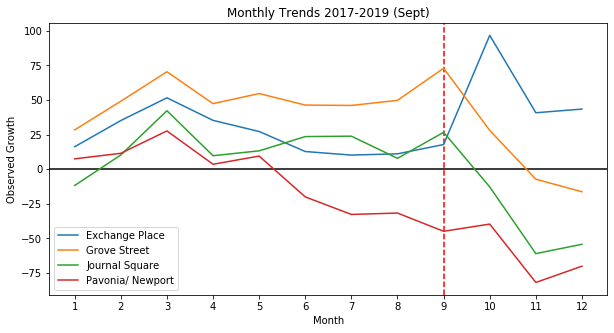

CONCLUSION: We're seeing moderate increases in PATH ridership over the past 3 years, but how will these people get to the PATH stations?


In [47]:
print("We will look at how each month's ridership has changes compared to previous years")
print("Ex: At Month 1, if positive, then we saw an increase in January ridership in the last 3 years")
monthly_data = {}
for station in stations:
    sample_gs = path_ridership[(path_ridership['Station'] == station) ].copy()
    sample_gs = sample_gs.sort_values(['Year', 'Month'], ascending=[True, True])

    sample_gs['yyyymm'] = sample_gs['Year'].apply(str) + sample_gs['Month'].apply(lambda x: str(x).zfill(2))
    sample_gs.reset_index(level=0, inplace=True)
    sample_gs['index'] = sample_gs.index

    growth_per_month = get_month_to_month_ridership_trends(sample_gs, months, station)
    monthly_data[station] = growth_per_month

plt.figure(figsize=(10,5))
plt.title("Monthly Trends 2017-2019 (Sept)")
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel("Observed Growth")
plt.axvline(x=9, color='r', linestyle='--')
plt.axhline(y=0, color='k')
for station in stations:
    coefs = monthly_data[station]
    plt.plot(months, coefs, label=station)
plt.legend(loc='lower left')
plt.show()

print("CONCLUSION: We're seeing moderate increases in PATH ridership over the past 3 years, but how will these people get to the PATH stations?")


In [48]:
print("Now lets look at the hourly trends, especifically rush hours timeframes") 

Now lets look at the hourly trends, especifically rush hours timeframes


In [50]:
print("Let's collect and join the average hourly PATH ridership data, and extract some unique values")

years = [2017, 2018, 2019]
stations = ['Journal Square', 'Grove Street', 'Exchange Place', 'Newport']

path_hourly_ridership = pd.DataFrame()
for year in years: 
    temp = pd.read_csv("../data/path_ridership_data/{}-PATH-hourly-Ridership-Report.csv".format(year), thousands=',')
    temp['year'] = year # ridership data doesn't have the year, add it
    path_hourly_ridership = path_hourly_ridership.append(temp)

months = path_ridership.Month.unique()
months.sort()

## filter for stations we're interested in 
path_hourly_ridership = path_hourly_ridership[path_hourly_ridership['station'].isin(stations)]

## format time column
path_hourly_ridership['Hour'] = pd.to_datetime(path_hourly_ridership['Hour']).dt.strftime('%H:%M:%S')
path_hourly_ridership.head()

Let's collect and join the average hourly PATH ridership data, and extract some unique values


,Hour,Avg Weekday Entry,Avg Saturday Entry,Avg Sunday Entry,Avg Weekday Exit,Avg Saturday Exit,Avg Sunday Exit,Avg Holiday Entries,Avg Holiday Exits,month,station,year
2304,00:00:00,39,76,84,351,664,547,49,453,1,Journal Square,2017
2305,01:00:00,23,42,51,234,330,717,22,270,1,Journal Square,2017
2306,02:00:00,30,32,49,118,251,404,21,137,1,Journal Square,2017
2307,03:00:00,55,37,44,90,237,343,37,94,1,Journal Square,2017
2308,04:00:00,193,86,60,119,195,274,112,94,1,Journal Square,2017


In [51]:
# Group data by station and hour to get averages for the past 3 years of data
grouped_hr_data = path_hourly_ridership.groupby(['station','Hour'], as_index=False).mean()

hours = list(grouped_hr_data.Hour.unique())

# We're interested in this subset of hours 
morning_rush_hours = hours[6:11]
evening_rush_hours =  hours[16:21]

print("Morning Rush: {}".format(morning_rush_hours))
print("Evening Rush: {}".format(evening_rush_hours))
grouped_hr_data.head()

Morning Rush: ['06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00']
Evening Rush: ['16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00']


,station,Hour,Avg Weekday Entry,Avg Saturday Entry,Avg Sunday Entry,Avg Weekday Exit,Avg Saturday Exit,Avg Sunday Exit,Avg Holiday Entries,Avg Holiday Exits,month,year
0,Exchange Place,00:00:00,30.03125,49.34375,43.43750,153.25000,250.06250,172.28125,23.84375,106.78125,6.0,2017.875
1,Exchange Place,01:00:00,17.00000,26.21875,21.71875,66.12500,107.93750,98.96875,12.43750,58.03125,6.0,2017.875
2,Exchange Place,02:00:00,5.46875,9.28125,9.71875,27.00000,48.90625,52.68750,5.56250,25.06250,6.0,2017.875
3,Exchange Place,03:00:00,6.28125,7.46875,7.78125,16.62500,25.75000,23.09375,4.25000,10.21875,6.0,2017.875
4,Exchange Place,04:00:00,19.71875,7.68750,7.53125,26.78125,23.40625,27.28125,4.62500,11.00000,6.0,2017.875


In [52]:
# Let's get the total average number of riders during rush hour timeframes
rush_hour_summaries = pd.DataFrame(columns=['station','avg_morn_rush', 'avg_eve_rush'])

values = []
for station in stations:
    avg_total_morning_entry = grouped_hr_data[(grouped_hr_data.Hour.isin(morning_rush_hours))
                     &(grouped_hr_data.station==station)]['Avg Weekday Entry'].sum()
    avg_total_evening_exit = grouped_hr_data[(grouped_hr_data.Hour.isin(evening_rush_hours))
                 &(grouped_hr_data.station==station)]['Avg Weekday Exit'].sum()
    temp = {'station':station,'avg_morn_rush': avg_total_morning_entry,'avg_eve_rush':avg_total_evening_exit}
    values.append(temp)

rush_hour_summaries = pd.DataFrame(values)
rush_hour_summaries

,station,avg_morn_rush,avg_eve_rush
0,Journal Square,16446.00000,15499.53125
1,Grove Street,13759.00000,12959.43750
2,Exchange Place,7222.59375,6566.43750
3,Newport,8330.28125,8717.71875


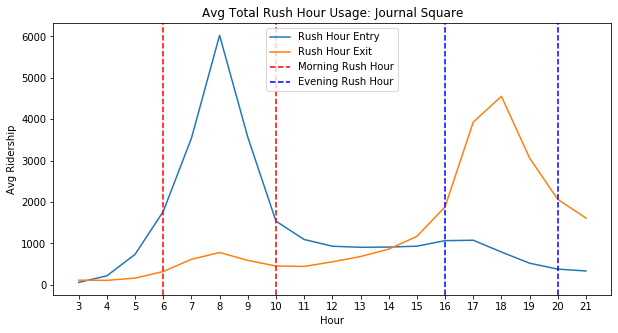

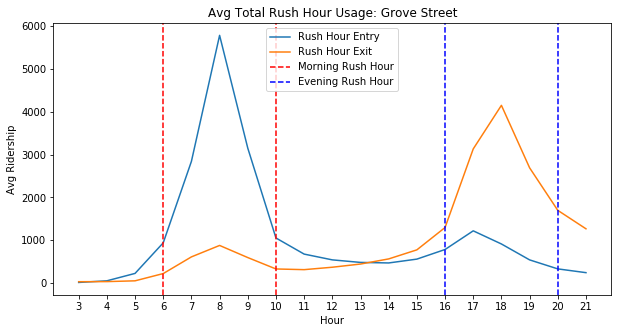

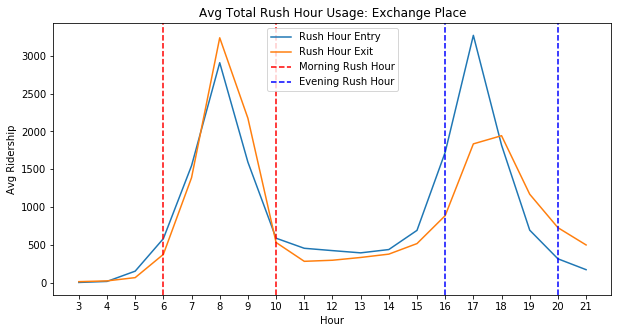

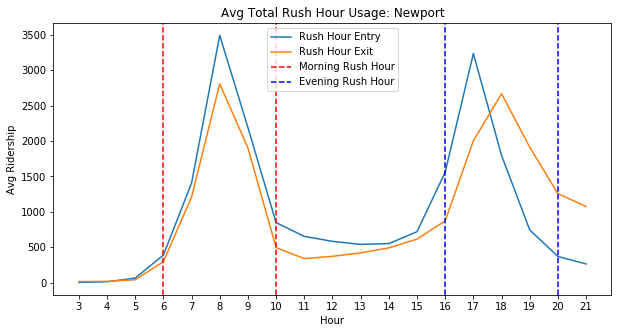

In [53]:
#Let's visualise these ridership averages 
desired_range = hours[3:22]
xlabels = np.arange(3,22,1)
for station in stations: 
    plt.figure(figsize=(10,5))
    plt.title("Avg Total Rush Hour Usage: {}".format(station))
    plt.xticks(xlabels)
    plt.xlabel('Hour')
    plt.ylabel("Avg Ridership")
    plt.plot(xlabels, grouped_hr_data[(grouped_hr_data['station'] ==station)&
                                      (grouped_hr_data['Hour'].isin(desired_range))]
             ['Avg Weekday Entry'], label='Rush Hour Entry')
    plt.plot(xlabels, grouped_hr_data[(grouped_hr_data['station'] ==station)&
                                      (grouped_hr_data['Hour'].isin(desired_range))]
             ['Avg Weekday Exit'], label='Rush Hour Exit')
    plt.axvline(x=6, color='r', linestyle='--', label='Morning Rush Hour')
    plt.axvline(x=10, color='r', linestyle='--')
    plt.axvline(x=16, color='b', linestyle='--', label='Evening Rush Hour')
    plt.axvline(x=20, color='b', linestyle='--')
    plt.legend(loc='upper center')
    plt.show()

In [54]:
# Let's figure out the average total riders (in the morning, and evening rush hours) per month, year, and station
# Note: We care only for people exiting the station in the evening because for our purposes 
### those would be the people who NEED to come back, our target audience for biking back home from the station 
avg_total_commuters = path_hourly_ridership[(path_hourly_ridership['Hour'].isin(morning_rush_hours))
                                         ].groupby(['station','year','month']).sum()
avg_total_commuters.rename(columns={"Avg Weekday Entry": "AvgTotalMorningRiders"}, inplace=True)

avg_total_commuters["AvgTotalEveningRiders"] = path_hourly_ridership[(path_hourly_ridership['Hour'].isin(evening_rush_hours))
                                                                    ].groupby(['station','year','month']).sum()["Avg Weekday Exit"]
avg_total_commuters.drop(columns=['Avg Saturday Entry', 'Avg Sunday Entry',
                                  'Avg Saturday Exit', 'Avg Sunday Exit', 'Avg Holiday Entries',
                                  'Avg Holiday Exits', 'Avg Weekday Exit'], inplace=True)

avg_total_commuters[avg_total_commuters.index.get_level_values('station') == 'Exchange Place']
avg_total_commuters.head()

AvgTotalMorningRiders  AvgTotalEveningRiders
station        year month                                              
Exchange Place 2017 1                       6289                   5797
                    2                       6220                   5661
                    3                       6223                   5725
                    4                       6535                   6034
                    5                       6696                   6142

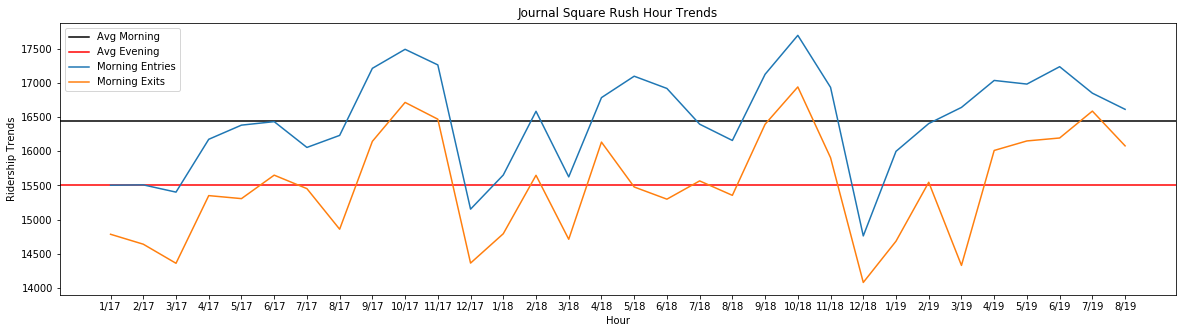

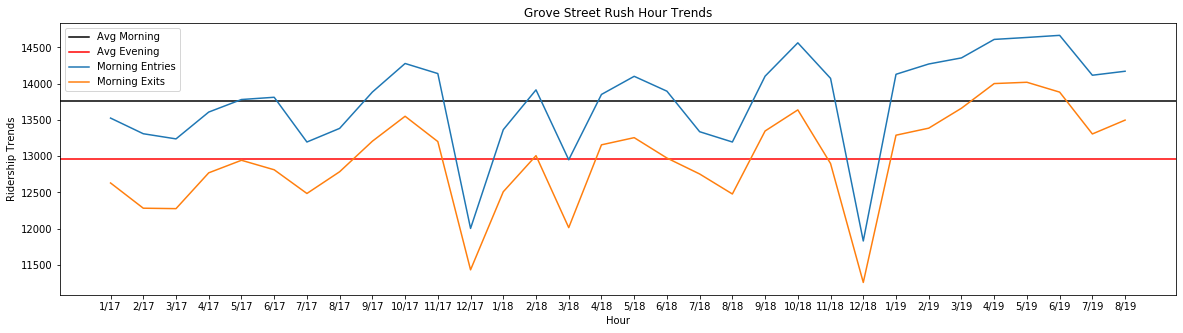

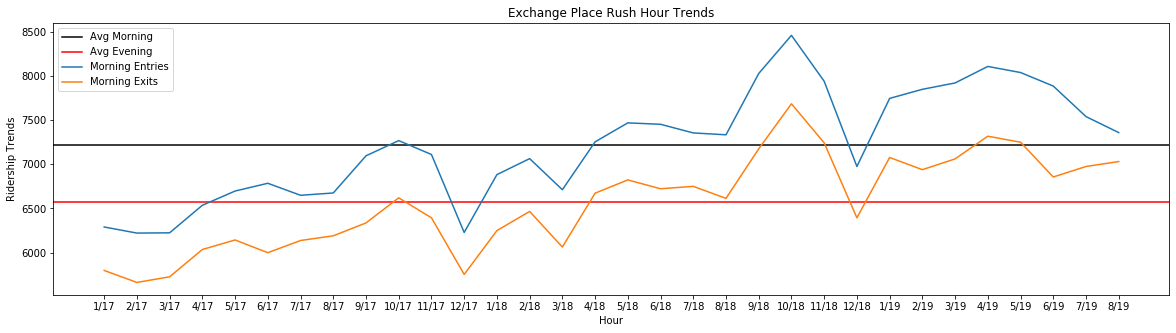

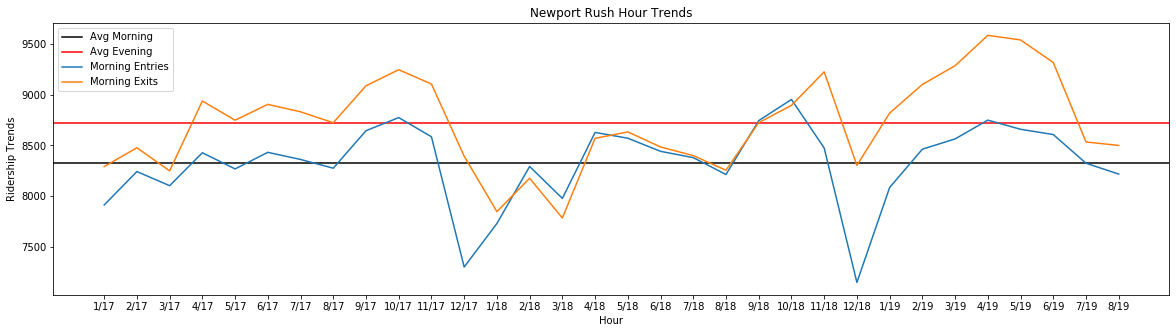

In [58]:
# Let's see how our previous averages compare to the monthly changes 

# Let's reformat the dates for chart display
dates = []
for year in years:
    for month in months:
        dates.append("{}/{}".format(month,str(year)[2:]))

daterange = dates[:-4] # TODO: for 2019 we only have data up until AUGUST 2019
for station in stations:
    plt.figure(figsize=(20,5))
    plt.title("{} Rush Hour Trends".format(station))
    plt.xlabel('Hour')
    plt.ylabel("Ridership Trends")    
    plt.axhline(y=rush_hour_summaries[rush_hour_summaries['station']==station]['avg_morn_rush'].values[0], 
                label='Avg Morning',color='k')
    plt.axhline(y=rush_hour_summaries[rush_hour_summaries['station']==station]['avg_eve_rush'].values[0], 
                label='Avg Evening', color='r')
    
    plt.plot(daterange, avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)]
             ['AvgTotalMorningRiders'], label='Morning Entries'.format())
    plt.plot(daterange, avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)]
             ['AvgTotalEveningRiders'], label='Morning Exits'.format())
    plt.legend(loc='upper left')
    plt.show()


In [62]:
# Let's do some seasonal decomposition to really gain insight into how each station's ridership is changing over the years
decompositions = []
for station in stations: 
    res_morning  = sm.tsa.seasonal_decompose(
        avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)
                           ]['AvgTotalMorningRiders'],model='additive', freq=12)
    res2_evening = sm.tsa.seasonal_decompose(
        avg_total_commuters[(avg_total_commuters.index.get_level_values('station') == station)
                           ]['AvgTotalEveningRiders'],model='additive', freq=12)
    decompositions.append([station, res_morning, res2_evening])

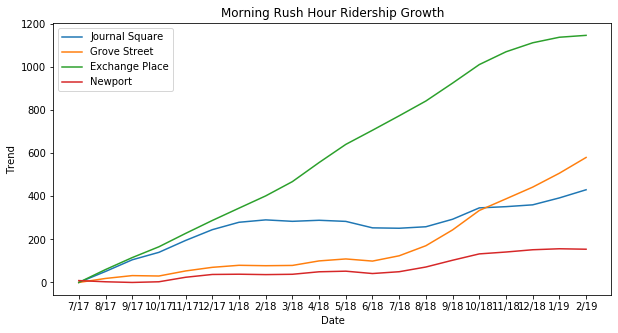

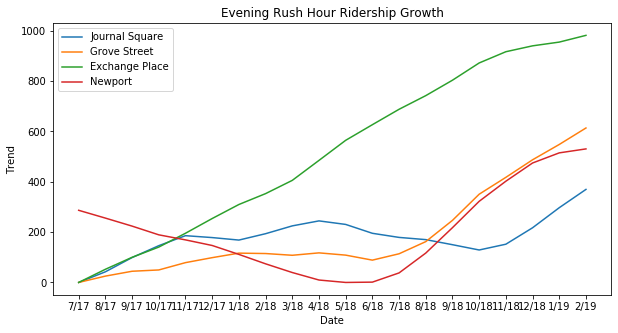

As we can see all 4 stations went through moderate growth in ridership


In [88]:
plt.figure(figsize=(10,5))
plt.title("Morning Rush Hour Ridership Growth".format())
plt.xlabel('Date')
plt.ylabel("Trend")  
for decomp in decompositions:
    station = decomp[0]
    morning = decomp[1]
    morning_rebased = morning.trend - morning.trend.min()
    plt.plot(daterange, morning_rebased, label='{}'.format(station))
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.title("Evening Rush Hour Ridership Growth".format())
plt.xlabel('Date')
plt.ylabel("Trend")  
for decomp in decompositions:
    station = decomp[0]
    evening = decomp[2]
    evening_rebased = evening.trend - evening.trend.min()
    plt.plot(daterange, evening_rebased, label='{}'.format(station))
plt.legend(loc='upper left')
plt.show()

print("As we can see all 4 stations went through moderate growth in ridership")

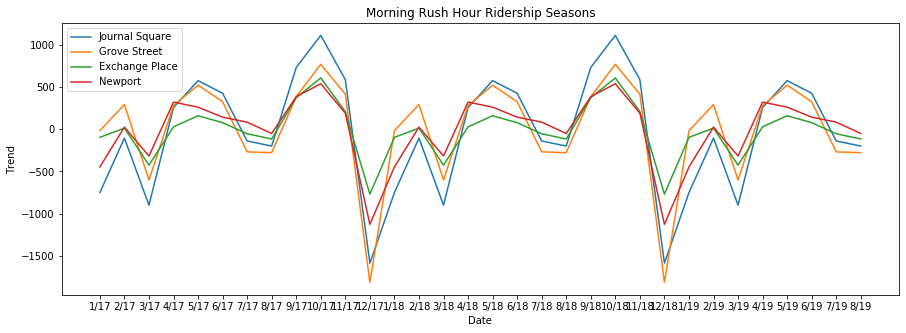

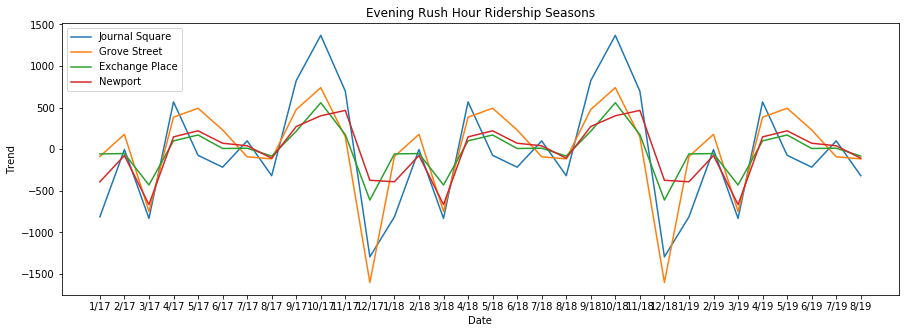

We can see that seasonality varies between [1000,-1500] at most, with december being a drop for all stations


In [89]:
# Let's also visualize seasonal components
plt.figure(figsize=(15,5))
plt.title("Morning Rush Hour Ridership Seasons".format())
plt.xlabel('Date')
plt.ylabel("Trend")  
for decomp in decompositions:
    station = decomp[0]
    morning = decomp[1]
    morning_rebased = morning.seasonal 
    plt.plot(daterange, morning_rebased, label='{}'.format(station))
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(15,5))
plt.title("Evening Rush Hour Ridership Seasons".format())
plt.xlabel('Date')
plt.ylabel("Trend")  
for decomp in decompositions:
    station = decomp[0]
    evening = decomp[2]
    evening_rebased = evening.seasonal
    plt.plot(daterange, evening_rebased, label='{}'.format(station))
plt.legend(loc='upper left')
plt.show()

print("We can see that seasonality varies between [1000,-1500] at most, with december being a drop for all stations")